In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import time
import os
import sys
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import photxspec
import corrfuncs
import linear_theory
import tools

### compare dark matter correlation functions

- DM 2pcf from TNG pair counts
- linear matter 2pcf from Colossus
- non-linear matter 2pcf from Colossus ?

#### load TNG snapshot

In [3]:
redshift = 1.
sim = TNGSim('TNG300-3', redshift=redshift)
chi = tools.redshift_to_comov(sim.redshift)  # comoving distance to the center of the box

# load the dark matter particles
dm_pos = sim.dm_pos()
# and get a random subsample - otherwise computing the pair counts takes a longg time
dm_subsample = tools.get_subsample(dm_pos, nx=1000, verbose=True)
dm_subsample = tools.remove_values(dm_subsample, minimum=0, maximum=sim.boxsize)

# also load the galaxy sample
sigma_z = 0.03  # one of the SPHEREx error bins
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]

loaded 244140625 dark matter particles
subsampling 244140 random particles...
 number density for SPHEREx at z=1.0: 2.12e-04 (h/Mpc)^3 
target number of subhalos: 1826


In [4]:
# inputs
rmin = 0.1
rmax = 100
nbins = 15

In [5]:
# 1. DM 2pcf from TNG pair counts
r_avg, xi = corrfuncs.compute_xi_auto(dm_subsample, rmin, rmax, nbins, logbins=True, boxsize=sim.boxsize,
                                     periodic=True)

In [16]:
# 2. linear matter 2pcf from Colossus
xi_lin = tools.linear_2pcf(sim.redshift, r_avg)

In [17]:
# 3. also compute the galaxy 2pcf from TNG pair counts
r_avg, xi_gal = corrfuncs.compute_xi_auto(gal_pos_spec, rmin, rmax, nbins, logbins=True, boxsize=sim.boxsize)

/work/08811/aew492/frontera/small-scale_cross-corrs/corrfuncs.py:87: RuntimeWarning: Mean of empty slice
  xi = np.nanmean(xis, axis=0)  # get the mean across the runs


Text(0, 0.5, 'Ratio')

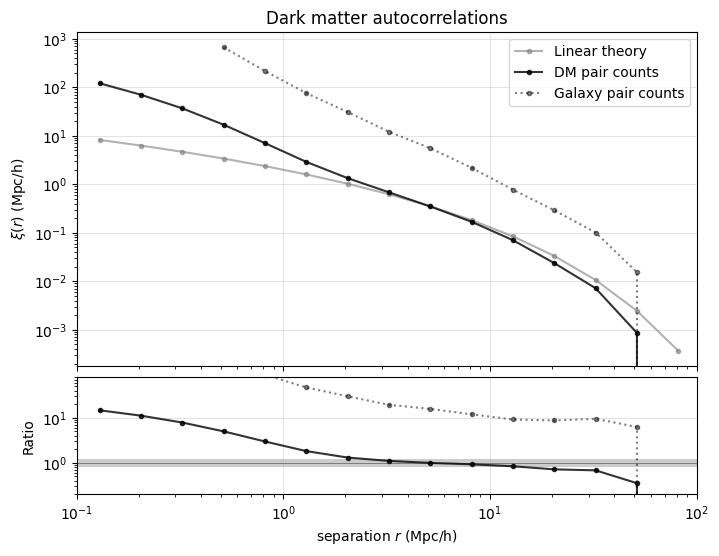

In [18]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.35], hspace=0.05)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
for ax in (ax0, ax1):
    ax.loglog()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlim(1e-1, 1e2)
    
ax0.plot(r_avg, xi_lin, c='grey', alpha=0.6, marker='.', label='Linear theory')
ax0.plot(r_avg, xi, c='k', alpha=0.8, marker='.', label='DM pair counts')
ax0.plot(r_avg, xi_gal, c='k', alpha=0.5, marker='.', ls=':', label='Galaxy pair counts')
ax0.set_xticks(np.logspace(-1,2,4), labels=[])
ax0.set_ylabel(r'$\xi(r)$ (Mpc/h)')
ax0.set_title(f"Dark matter autocorrelations")
ax0.legend()

ax1.loglog()
ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
ax1.plot(r_avg, xi / xi_lin, c='k', alpha=0.8, marker='.')
ax1.plot(r_avg, xi_gal / xi_lin, c='k', alpha=0.5, marker='.', ls=':')
ax1.axhline(1., alpha=0.5, c='k', lw=0.5)
ax1.set_ylim(2e-1, 8e1)
ax1.set_xlabel(r'separation $r$ (Mpc/h)')
ax1.set_ylabel(r'Ratio')

### compare galaxy bias

1.
$$
b = \frac{\xi_\mathrm{GalxDM}(r)}{\xi_\mathrm{DM,lin}(r)}
$$

2.
$$
b = \sqrt{\frac{\xi_\mathrm{GalxGal}(r)}{\xi_\mathrm{DM,lin}(r)}}
$$

In [19]:
# 1. from galaxy-matter cross-correlation - already have a function for this
_, ratio1 = linear_theory.get_linear_bias(gal_pos_spec, sim, rmin, rmax, nbins, return_ratio=True)

loaded 244140625 dark matter particles


In [20]:
# range to compute linear bias
biasrange = [-8,-3] # indices from ravg
bias1 = np.mean(ratio1[biasrange[0]:biasrange[1]])

In [21]:
# 2. from galaxy-galaxy cross-correlation - already computed above
ratio2 = np.sqrt(xi_gal / xi_lin)
bias2 = np.mean(ratio2[biasrange[0]:biasrange[1]])

/work/08811/aew492/frontera/venv/illustris/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


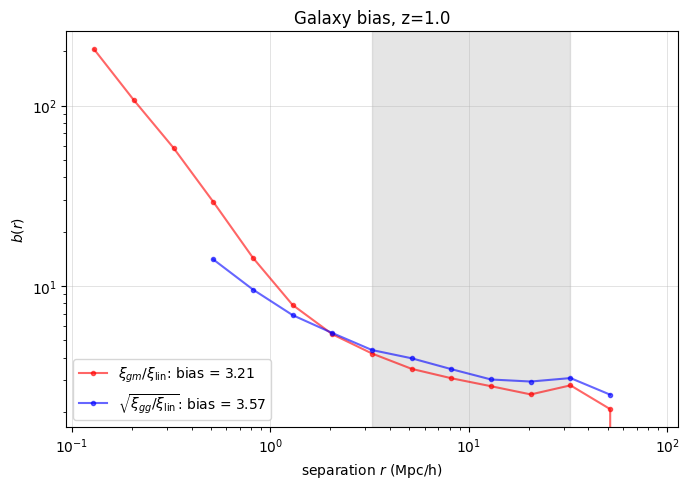

In [22]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(r_avg, ratio1, 'r.-', alpha=0.6, label=r'$\xi_{gm}/\xi_\mathrm{lin}$:'f' bias = {bias1:.2f}')
ax.plot(r_avg, ratio2, 'b.-', alpha=0.6, label=r'$\sqrt{\xi_{gg}/\xi_\mathrm{lin}}$:'f' bias = {bias2:.2f}')
ax.axvspan(r_avg[biasrange[0]], r_avg[biasrange[1]], color='grey', alpha=0.2)
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$b(r)$')
ax.set_title(f'Galaxy bias, z={sim.redshift}')
ax.legend()